# Pricing Test


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy.stats import ttest_ind

%matplotlib inline

In [2]:
user_table = pd.read_csv('data/user_table.csv')
user_table.head(5)

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [3]:
user_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  275616 non-null  int64  
 1   city     275616 non-null  object 
 2   country  275616 non-null  object 
 3   lat      275616 non-null  float64
 4   long     275616 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


In [4]:
user_table.isnull().sum()

user_id    0
city       0
country    0
lat        0
long       0
dtype: int64

In [5]:
test_results = pd.read_csv('data/test_results.csv')
test_results.head(5)

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [6]:
test_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           316800 non-null  int64 
 1   timestamp         316800 non-null  object
 2   source            316800 non-null  object
 3   device            316800 non-null  object
 4   operative_system  316800 non-null  object
 5   test              316800 non-null  int64 
 6   price             316800 non-null  int64 
 7   converted         316800 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


In [7]:
test_results.isnull().sum().any()

False

## Preprocessing

Merge both tables on user ID

In [8]:
data = pd.merge(left= test_results, right = user_table, how='left', on='user_id')
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [9]:
data.isnull().sum()

user_id                 0
timestamp               0
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
city                41184
country             41184
lat                 41184
long                41184
dtype: int64

There are some null values because the user_table has fewer entries than the test_results

In [10]:
#check that the correct group sees the correct price
data[['price', 'user_id','test']].groupby(['test', 'price']).count()

user_id
test price         
0    39      202517
     59         210
1    39         155
     59      113918

Some people from test 0 sees price 59, and some people from test 1 sees price 39. But this is a small percentage, so can be removed.

In [11]:
data = data[((data['test']==0) & (data['price']==39)) | ((data['test']==1) & (data['price']==59))]

In [12]:
#new field revenue, to check which price should be kept by the company

data['revenue'] = data['converted'] * data['price']

data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,revenue
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02,0


## Exploratory Data Analysis

### Source Randomness

In [20]:
#Check for randomness of source

tmp = data.groupby('test')['source'].apply(lambda x: x.value_counts(normalize=True)).unstack()
tmp

,ads-bing,ads-google,ads-yahoo,ads_facebook,ads_other,direct_traffic,friend_referral,seo-bing,seo-google,seo-other,seo-yahoo,seo_facebook
test,,,,,,,,,,,,
0,0.072014,0.186873,0.023761,0.168253,0.095083,0.191154,0.064790,0.006562,0.074502,0.029030,0.021509,0.066468
1,0.072394,0.188706,0.024219,0.169253,0.092786,0.189259,0.066337,0.007154,0.070753,0.029539,0.021814,0.067786


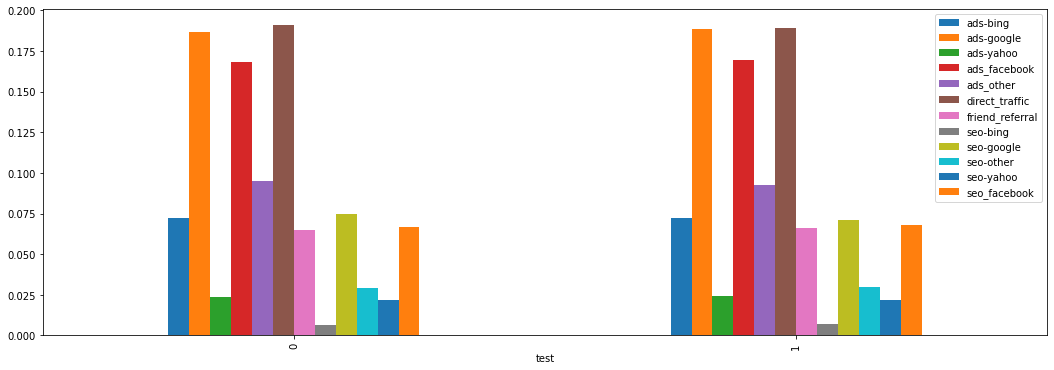

In [21]:
fig, ax = plt.subplots(figsize=(18, 6))
tmp.plot(kind='bar', ax=ax)
plt.show()

In [22]:
data[['price', 'test', 'user_id']].groupby(['test', 'price']).count()

,,user_id
test,price,
0,39,202517
1,59,113918


In [33]:
count = data[['source', 'test','revenue']].groupby(['source','test']).count().reset_index()
count.head(5)

,source,test,revenue
0,ads-bing,0,14584
1,ads-bing,1,8247
2,ads-google,0,37845
3,ads-google,1,21497
4,ads-yahoo,0,4812


In [34]:
#Find percentage
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / 113918
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue'] / 202517
count.head()

,source,test,revenue
0,ads-bing,0,0.072014
1,ads-bing,1,0.072394
2,ads-google,0,0.186873
3,ads-google,1,0.188706
4,ads-yahoo,0,0.023761


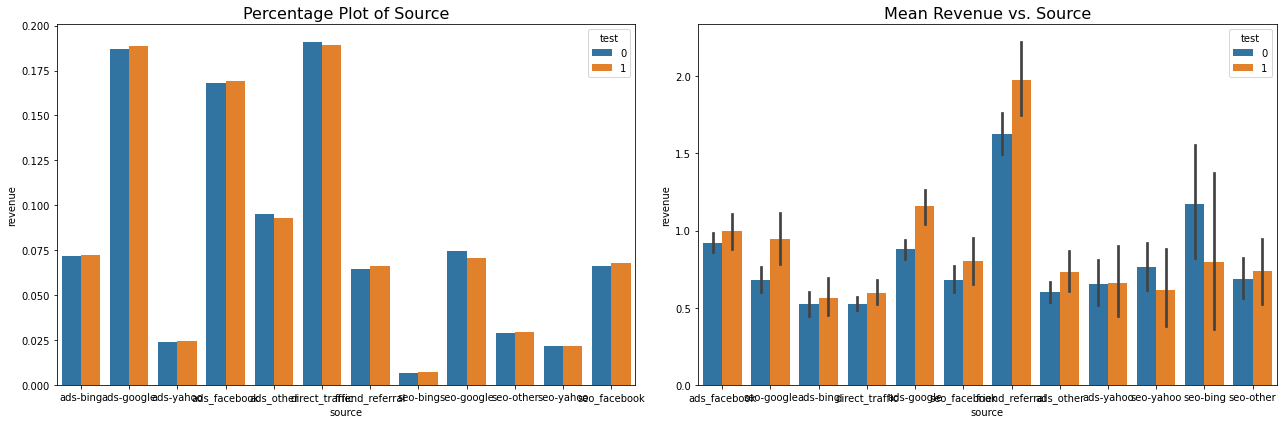

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='source', y='revenue', hue='test', data=count, ax=ax[0])
ax[0].set_title('Percentage Plot of Source', fontsize=16)

sns.barplot(x='source', y='revenue', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Revenue vs. Source', fontsize=16)
plt.tight_layout()
plt.show()

### Device Randomness

In [36]:
tmp = data.groupby('test')['device'].apply(lambda x: x.value_counts(normalize=True)).unstack()
tmp

,mobile,web
test,,
0,0.594365,0.405635
1,0.578469,0.421531


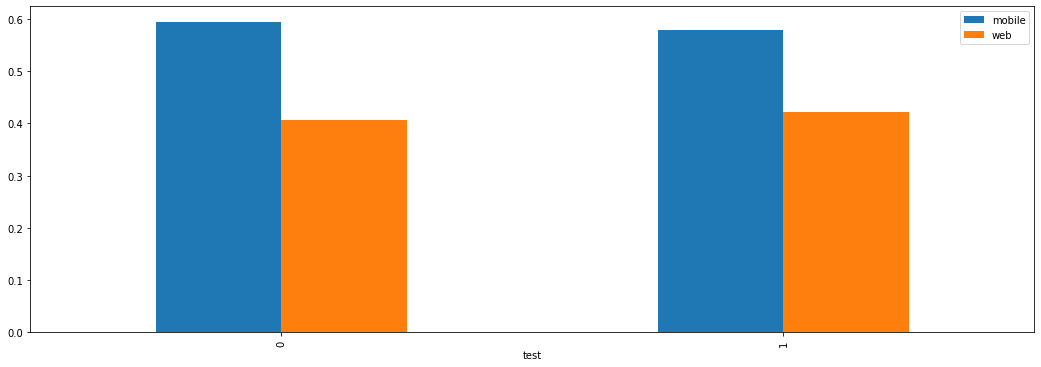

In [37]:
fig, ax = plt.subplots(figsize=(18, 6))
tmp.plot(kind='bar', ax=ax)
plt.show()

In [39]:
count = data[['device', 'test','revenue']].groupby(['device','test']).count().reset_index()
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / 113918
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue'] / 202517
count.head(5)

,device,test,revenue
0,mobile,0,0.594365
1,mobile,1,0.578469
2,web,0,0.405635
3,web,1,0.421531


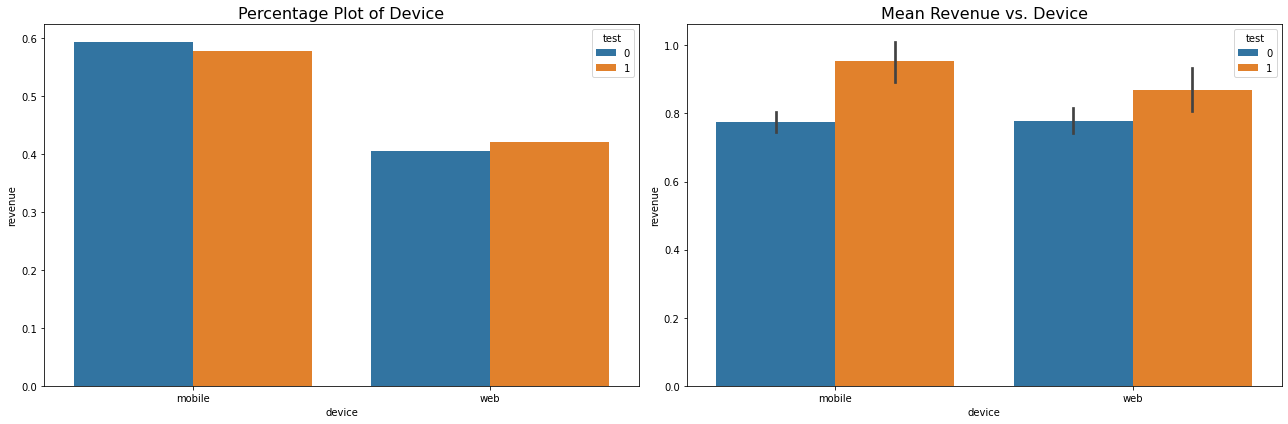

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='device', y='revenue', hue='test', data=count, ax=ax[0])
ax[0].set_title('Percentage Plot of Device', fontsize=16)

sns.barplot(x='device', y='revenue', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Revenue vs. Device', fontsize=16)
plt.tight_layout()
plt.show()

### Operating System

In [41]:
tmp = data.groupby('test')['operative_system'].apply(lambda x: x.value_counts(normalize=True)).unstack()
tmp

,windows,iOS,android,mac,other,linux
test,,,,,,
0,0.313638,0.305125,0.237891,0.080709,0.051754,0.010883
1,0.327718,0.294598,0.234318,0.076459,0.050001,0.016907


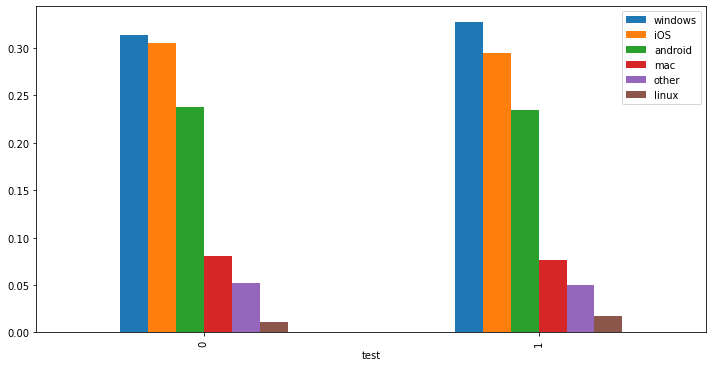

In [42]:
fig, ax = plt.subplots(figsize=(12, 6))
tmp.plot(kind='bar', ax=ax)
plt.show()

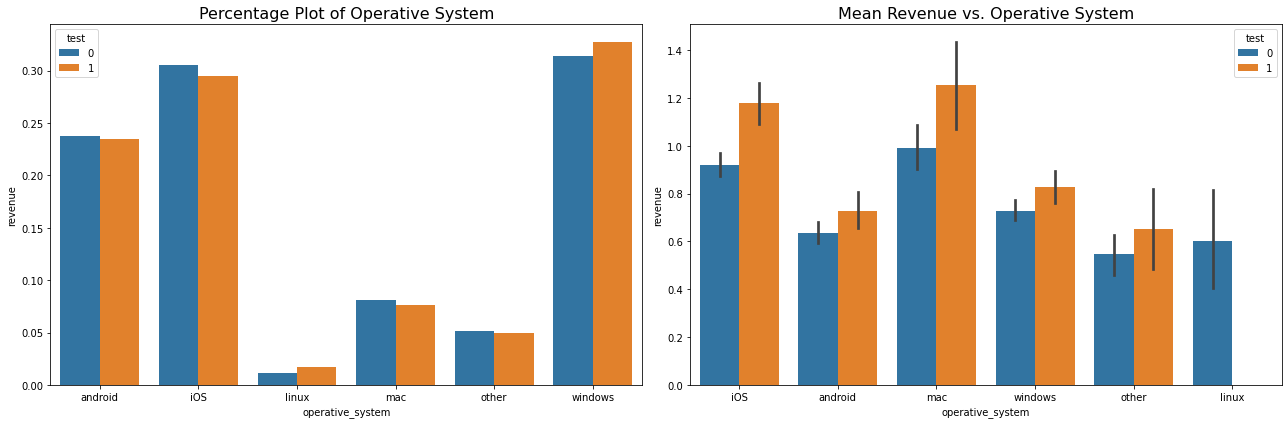

In [43]:
count = data[['operative_system', 'test', 'revenue']].groupby(['operative_system', 'test']).count().reset_index()
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / 113918
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue'] / 202517

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='operative_system', y='revenue', hue='test', data=count, ax=ax[0])
ax[0].set_title('Percentage Plot of Operative System', fontsize=16)

sns.barplot(x='operative_system', y='revenue', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Revenue vs. Operative System', fontsize=16)
plt.tight_layout()
plt.show()

Data is not super well randomised

## Question 1
Should the company sell its software for 39 or 59?

In [44]:
#check conversion rate

data[['test','converted']].groupby('test').mean()

,converted
test,
0,0.019900
1,0.015555


In [45]:
#check revenue rate
data[['test','revenue']].groupby('test').mean()

,revenue
test,
0,0.776083
1,0.917748


Lower price has higher conversion rate but less revenue.

Now, let's conduct hypothesis testing.

Null hypothesis H0: experimental group's average revenue is equal to or less than control group's average revenue

Alternative hypothesis H1: experimental group's average revenue is higher than control group's average revenue

In [46]:
control_values = data[data['test'] == 0]['revenue'].values
experimental_values = data[data['test'] == 1]['revenue'].values

In [47]:
# T-Test
print(ttest_ind(control_values, experimental_values, axis=0, equal_var=False))

Ttest_indResult(statistic=-5.715224666463108, pvalue=1.0972577312420781e-08)


Since the p-value is small, there is a difference between the conversion proportions between the group having 39 dollar product anf group having 59 dollar product. There is a 21% drop in conversion (from 1.99 to 1.55).
We reject the null hypothesis, and cinclude that the test group has a higher revenue.

## Question 2

The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?

In [56]:
#source conversion- check how did the user come to our website

data.groupby('source')['converted'].mean().reset_index().sort_values('converted', ascending=False)

,source,converted
6,friend_referral,0.038688
7,seo-bing,0.023787
1,ads-google,0.021502
3,ads_facebook,0.021198
8,seo-google,0.016978
10,seo-yahoo,0.016226
11,seo_facebook,0.016051
9,seo-other,0.015686
2,ads-yahoo,0.014793
4,ads_other,0.014350


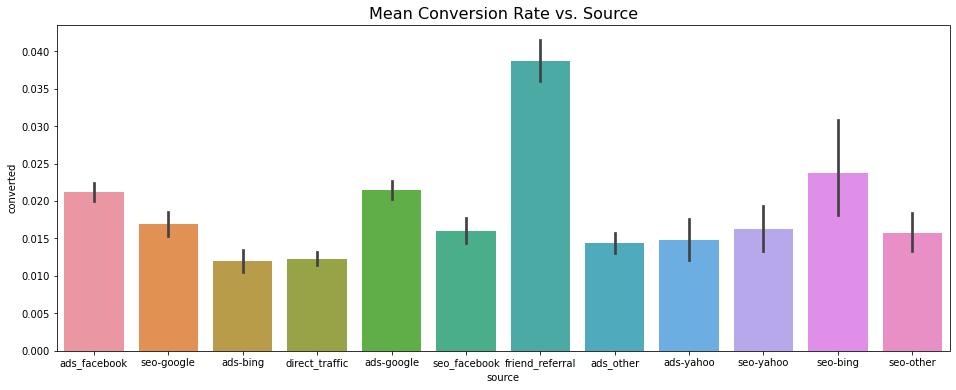

In [57]:
#visualising
# Visualization of source
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x='source', y='converted', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Source', fontsize=16)
plt.show()

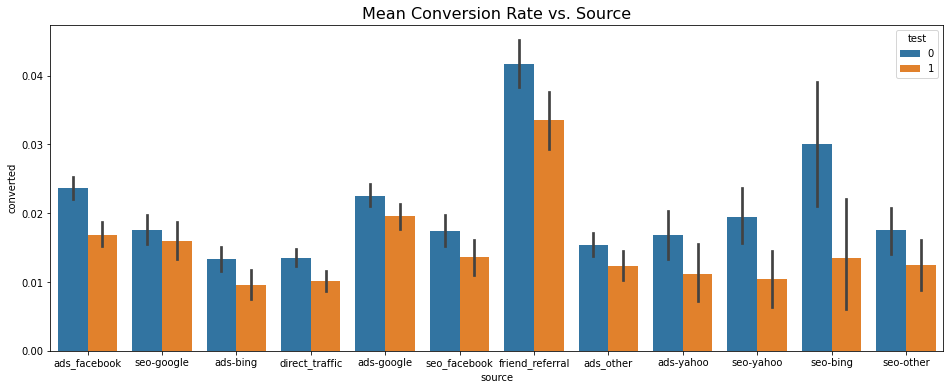

In [58]:
# Visualization of source
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x='source', y='converted', hue='test', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Source', fontsize=16)
plt.show()

In [59]:
#device conversion
data.groupby('device')['converted'].mean().reset_index().sort_values('converted', ascending=False)

,device,converted
0,mobile,0.018554
1,web,0.018023


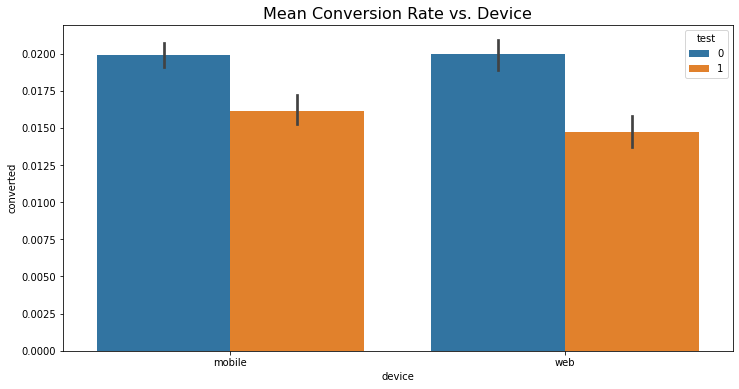

In [60]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='device', y='converted', hue='test', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Device', fontsize=16)
plt.show()

In [61]:
#operation system conversion

data.groupby('operative_system')['converted'].mean().reset_index().sort_values('converted', ascending=False)

,operative_system,converted
3,mac,0.023987
1,iOS,0.022328
5,windows,0.016966
0,android,0.014919
4,other,0.012981
2,linux,0.008232


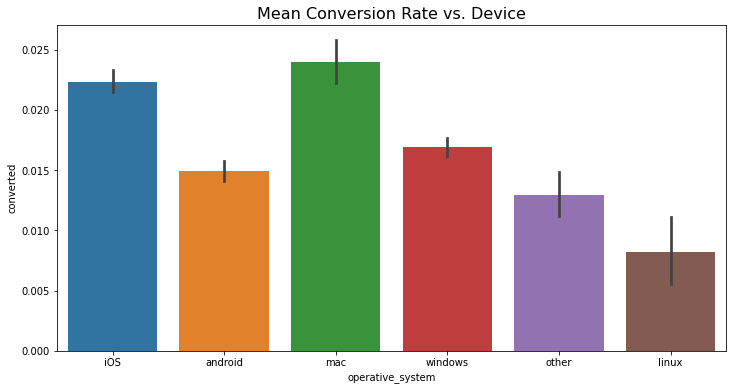

In [62]:
fix, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='operative_system', y='converted', data = data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Device', fontsize=16)
plt.show()

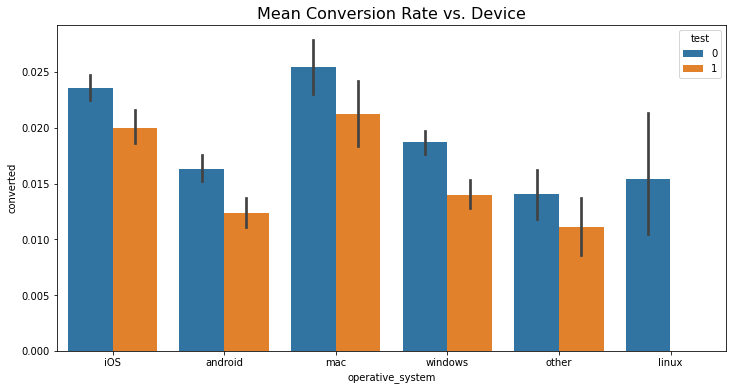

In [63]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='operative_system', y='converted', hue='test', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Device', fontsize=16)
plt.show()

In [64]:
data[['test', 'converted','revenue']].groupby('test').mean()

,converted,revenue
test,,
0,0.019900,0.776083
1,0.015555,0.917748


### Observations

Other than the price, we see that the following factors influence the conversion rate:
1. Source: friend referals result in more conversion
2. Device: does not influence conversion too much
3. OS: Mac/iOS users have a higher conversion rate

Thus, if we are increasing the price (which decreases conversion rate), maybe we should target apple users/ encourage friend referals. Moreover, find out why linux users dont like the product too much.